# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # TODO: Implement function and return a dataloader
    dataset = datasets.ImageFolder(root = data_dir, transform=transform)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

C:\Users\81019188\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


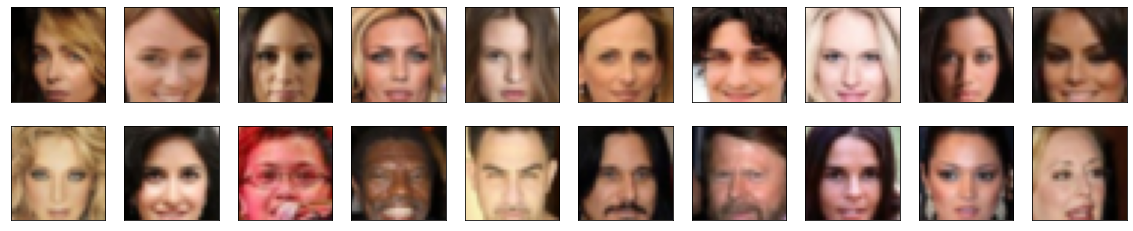

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    return x * (max - min) + min


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8902)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# Fcnction to test output dimension
def out_conv2d(dim_input, padding, kernel_size, dilation=1, stride=1):
    dim_output = ((dim_input + 2 * padding - dilation * (kernel_size-1) - 1)/stride) + 1
    return dim_output

print(out_conv2d(dim_input=32, padding=1, kernel_size=3, dilation=1, stride=1))

# Fcnction to test output dimension
def out_t_conv2d(dim_input, padding, kernel_size, dilation=1, stride=1, output_padding=0):
    dim_output = (dim_input-1) * stride - 2 * padding + dilation * (kernel_size-1) + output_padding + 1
    return dim_output

print(out_t_conv2d(dim_input=4, padding=1, kernel_size=4, dilation=1, stride=2, output_padding=0))

32.0
8


In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # 32x32 input
        self.conv1 = conv(3, self.conv_dim, 4, batch_norm=False)
        # 16x16 out
        self.conv2 = conv(self.conv_dim, self.conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(self.conv_dim*2, self.conv_dim*4, 4)
        # 4x4 out
        self.conv4 = conv(self.conv_dim*4, self.conv_dim*8, 4)
        # 2x2 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(self.conv_dim*8 * 2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        out = out.view(-1, self.conv_dim*8 * 2*2)
        
        out = self.fc(out)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.z_size = z_size
        
        self.fc = nn.Linear(self.z_size, self.conv_dim*8 * 2*2)
        
        # input 2x2
        self.t_conv1 = deconv(self.conv_dim*8, self.conv_dim*4, 4)
        # out 4x4
        self.t_conv2 = deconv(self.conv_dim*4, self.conv_dim*2, 4)
        # out 8x8
        self.t_conv3 = deconv(self.conv_dim*2, self.conv_dim, 4)
        # out 16x16
        self.t_conv4 = deconv(self.conv_dim, 3, 4, batch_norm=False)
        # out 32x32
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        out = self.fc(x)
        
        out = out.view(-1, self.conv_dim*8, 2, 2)
        
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


C:\Users\81019188\.conda\envs\udacity\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # for every Linear or Conv2d layer in a model..
    if classname.find('Linear') != -1 and classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
        #m.bias.data.fill_(0)
        
    # TODO: Apply initial weights to convolutional and linear layers
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 128
z_size = 150

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=150, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=[0.5, 0.999])
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=[0.5, 0.999])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            # Train with real images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step() 

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # Train with fake images and flipped labels
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3231 | g_loss: 2.0420
Epoch [    1/   50] | d_loss: 0.1754 | g_loss: 7.9318
Epoch [    1/   50] | d_loss: 0.0097 | g_loss: 8.7260
Epoch [    1/   50] | d_loss: 0.4429 | g_loss: 4.7453
Epoch [    1/   50] | d_loss: 0.5155 | g_loss: 2.8954
Epoch [    1/   50] | d_loss: 0.7237 | g_loss: 1.4674
Epoch [    1/   50] | d_loss: 0.6215 | g_loss: 2.6987
Epoch [    1/   50] | d_loss: 0.5625 | g_loss: 2.6285
Epoch [    1/   50] | d_loss: 1.2180 | g_loss: 1.5218
Epoch [    1/   50] | d_loss: 0.5417 | g_loss: 2.8992
Epoch [    1/   50] | d_loss: 0.3639 | g_loss: 2.6138
Epoch [    1/   50] | d_loss: 0.9763 | g_loss: 1.3091
Epoch [    1/   50] | d_loss: 0.6987 | g_loss: 2.4298
Epoch [    1/   50] | d_loss: 1.0293 | g_loss: 4.3303
Epoch [    1/   50] | d_loss: 0.4389 | g_loss: 2.4176
Epoch [    1/   50] | d_loss: 0.4313 | g_loss: 1.9947
Epoch [    1/   50] | d_loss: 0.9616 | g_loss: 5.9537
Epoch [    1/   50] | d_loss: 0.4914 | g_loss: 2.1655
Epoch [    1/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.1820 | g_loss: 2.0656
Epoch [    6/   50] | d_loss: 0.0868 | g_loss: 6.0536
Epoch [    6/   50] | d_loss: 0.1363 | g_loss: 7.6221
Epoch [    6/   50] | d_loss: 0.0419 | g_loss: 4.7697
Epoch [    6/   50] | d_loss: 0.0065 | g_loss: 5.3136
Epoch [    6/   50] | d_loss: 0.1086 | g_loss: 4.1075
Epoch [    6/   50] | d_loss: 0.0022 | g_loss: 7.6382
Epoch [    6/   50] | d_loss: 0.0998 | g_loss: 2.7411
Epoch [    6/   50] | d_loss: 0.0014 | g_loss: 8.1098
Epoch [    6/   50] | d_loss: 0.0028 | g_loss: 6.9715
Epoch [    6/   50] | d_loss: 0.0012 | g_loss: 8.0834
Epoch [    6/   50] | d_loss: 6.0776 | g_loss: 5.4394
Epoch [    6/   50] | d_loss: 0.4607 | g_loss: 3.3015
Epoch [    6/   50] | d_loss: 0.2165 | g_loss: 3.1050
Epoch [    6/   50] | d_loss: 0.0583 | g_loss: 4.1500
Epoch [    6/   50] | d_loss: 0.2647 | g_loss: 2.9386
Epoch [    6/   50] | d_loss: 0.0065 | g_loss: 4.2693
Epoch [    6/   50] | d_loss: 0.0456 | g_loss: 4.5504
Epoch [    6/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.2362 | g_loss: 7.1949
Epoch [   11/   50] | d_loss: 0.2889 | g_loss: 4.7561
Epoch [   11/   50] | d_loss: 0.0701 | g_loss: 3.7403
Epoch [   11/   50] | d_loss: 0.0136 | g_loss: 7.4697
Epoch [   11/   50] | d_loss: 1.3629 | g_loss: 10.8912
Epoch [   11/   50] | d_loss: 0.0491 | g_loss: 5.2600
Epoch [   11/   50] | d_loss: 0.2467 | g_loss: 2.6934
Epoch [   11/   50] | d_loss: 0.0790 | g_loss: 5.0562
Epoch [   11/   50] | d_loss: 0.9095 | g_loss: 0.8710
Epoch [   11/   50] | d_loss: 0.0818 | g_loss: 4.3681
Epoch [   11/   50] | d_loss: 0.0309 | g_loss: 2.1192
Epoch [   11/   50] | d_loss: 0.0528 | g_loss: 2.9822
Epoch [   11/   50] | d_loss: 0.1082 | g_loss: 4.1876
Epoch [   11/   50] | d_loss: 0.0064 | g_loss: 9.1312
Epoch [   11/   50] | d_loss: 0.0384 | g_loss: 4.9822
Epoch [   12/   50] | d_loss: 1.5906 | g_loss: 8.2835
Epoch [   12/   50] | d_loss: 0.1797 | g_loss: 5.8062
Epoch [   12/   50] | d_loss: 0.0161 | g_loss: 3.1978
Epoch [   12/   50] | d_los

Epoch [   16/   50] | d_loss: 0.0271 | g_loss: 2.8987
Epoch [   16/   50] | d_loss: 0.6283 | g_loss: 7.0013
Epoch [   16/   50] | d_loss: 0.2554 | g_loss: 4.8108
Epoch [   16/   50] | d_loss: 0.0541 | g_loss: 4.1390
Epoch [   16/   50] | d_loss: 5.5739 | g_loss: 9.3216
Epoch [   16/   50] | d_loss: 0.2413 | g_loss: 4.3425
Epoch [   16/   50] | d_loss: 0.5204 | g_loss: 5.3120
Epoch [   16/   50] | d_loss: 0.0398 | g_loss: 5.7866
Epoch [   17/   50] | d_loss: 0.1800 | g_loss: 5.1094
Epoch [   17/   50] | d_loss: 0.0724 | g_loss: 5.8085
Epoch [   17/   50] | d_loss: 0.2541 | g_loss: 6.8467
Epoch [   17/   50] | d_loss: 0.0113 | g_loss: 1.8834
Epoch [   17/   50] | d_loss: 0.2354 | g_loss: 6.9707
Epoch [   17/   50] | d_loss: 0.0487 | g_loss: 5.5639
Epoch [   17/   50] | d_loss: 0.3998 | g_loss: 4.8361
Epoch [   17/   50] | d_loss: 0.0208 | g_loss: 4.8380
Epoch [   17/   50] | d_loss: 0.0369 | g_loss: 4.5600
Epoch [   17/   50] | d_loss: 0.0168 | g_loss: 4.4087
Epoch [   17/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.1584 | g_loss: 6.0412
Epoch [   22/   50] | d_loss: 0.0334 | g_loss: 4.4599
Epoch [   22/   50] | d_loss: 0.1959 | g_loss: 4.1228
Epoch [   22/   50] | d_loss: 0.0223 | g_loss: 7.1042
Epoch [   22/   50] | d_loss: 0.1501 | g_loss: 4.9685
Epoch [   22/   50] | d_loss: 0.0855 | g_loss: 7.5104
Epoch [   22/   50] | d_loss: 0.0386 | g_loss: 8.8759
Epoch [   22/   50] | d_loss: 0.0696 | g_loss: 1.8760
Epoch [   22/   50] | d_loss: 0.1347 | g_loss: 4.9068
Epoch [   22/   50] | d_loss: 0.0508 | g_loss: 8.0033
Epoch [   22/   50] | d_loss: 0.0628 | g_loss: 8.3537
Epoch [   22/   50] | d_loss: 0.2579 | g_loss: 7.3340
Epoch [   22/   50] | d_loss: 0.0787 | g_loss: 7.6357
Epoch [   22/   50] | d_loss: 0.1576 | g_loss: 2.0045
Epoch [   22/   50] | d_loss: 0.2216 | g_loss: 7.7785
Epoch [   22/   50] | d_loss: 0.0078 | g_loss: 2.5835
Epoch [   22/   50] | d_loss: 0.0465 | g_loss: 4.8148
Epoch [   22/   50] | d_loss: 0.0260 | g_loss: 3.3823
Epoch [   22/   50] | d_loss

Epoch [   27/   50] | d_loss: 1.2686 | g_loss: 2.0866
Epoch [   27/   50] | d_loss: 1.4173 | g_loss: 1.2534
Epoch [   27/   50] | d_loss: 0.3027 | g_loss: 4.7921
Epoch [   27/   50] | d_loss: 0.7174 | g_loss: 5.7849
Epoch [   27/   50] | d_loss: 0.2622 | g_loss: 4.3093
Epoch [   27/   50] | d_loss: 0.2530 | g_loss: 5.2779
Epoch [   27/   50] | d_loss: 0.1265 | g_loss: 3.9254
Epoch [   27/   50] | d_loss: 0.0357 | g_loss: 5.3488
Epoch [   27/   50] | d_loss: 0.1137 | g_loss: 4.6160
Epoch [   27/   50] | d_loss: 0.1248 | g_loss: 5.8507
Epoch [   27/   50] | d_loss: 0.2485 | g_loss: 8.9379
Epoch [   27/   50] | d_loss: 0.5375 | g_loss: 5.5845
Epoch [   27/   50] | d_loss: 0.2120 | g_loss: 4.1772
Epoch [   27/   50] | d_loss: 0.5125 | g_loss: 2.2750
Epoch [   27/   50] | d_loss: 0.1387 | g_loss: 3.2741
Epoch [   27/   50] | d_loss: 0.2155 | g_loss: 4.7823
Epoch [   27/   50] | d_loss: 0.1254 | g_loss: 3.9304
Epoch [   27/   50] | d_loss: 0.2120 | g_loss: 4.9937
Epoch [   27/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.1098 | g_loss: 6.1409
Epoch [   32/   50] | d_loss: 0.1846 | g_loss: 6.0659
Epoch [   32/   50] | d_loss: 0.1752 | g_loss: 3.1095
Epoch [   32/   50] | d_loss: 0.1609 | g_loss: 3.2123
Epoch [   32/   50] | d_loss: 0.2608 | g_loss: 5.1281
Epoch [   32/   50] | d_loss: 0.4912 | g_loss: 5.3055
Epoch [   32/   50] | d_loss: 0.2126 | g_loss: 4.8786
Epoch [   32/   50] | d_loss: 0.1658 | g_loss: 3.5215
Epoch [   32/   50] | d_loss: 0.4235 | g_loss: 4.4576
Epoch [   32/   50] | d_loss: 0.0592 | g_loss: 5.5811
Epoch [   32/   50] | d_loss: 0.5840 | g_loss: 2.3375
Epoch [   32/   50] | d_loss: 0.3286 | g_loss: 3.6204
Epoch [   32/   50] | d_loss: 0.0909 | g_loss: 3.7044
Epoch [   32/   50] | d_loss: 1.6794 | g_loss: 0.6650
Epoch [   32/   50] | d_loss: 0.7192 | g_loss: 1.6856
Epoch [   32/   50] | d_loss: 0.3916 | g_loss: 2.6981
Epoch [   33/   50] | d_loss: 0.3152 | g_loss: 2.8490
Epoch [   33/   50] | d_loss: 0.2235 | g_loss: 4.1658
Epoch [   33/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.1873 | g_loss: 2.1833
Epoch [   37/   50] | d_loss: 0.2240 | g_loss: 2.8268
Epoch [   37/   50] | d_loss: 0.1225 | g_loss: 3.3035
Epoch [   37/   50] | d_loss: 0.3433 | g_loss: 4.5312
Epoch [   37/   50] | d_loss: 0.5337 | g_loss: 5.5973
Epoch [   37/   50] | d_loss: 0.3936 | g_loss: 3.7315
Epoch [   37/   50] | d_loss: 0.5431 | g_loss: 3.0175
Epoch [   37/   50] | d_loss: 0.3146 | g_loss: 1.8097
Epoch [   37/   50] | d_loss: 0.1652 | g_loss: 4.2783
Epoch [   38/   50] | d_loss: 0.5522 | g_loss: 4.0193
Epoch [   38/   50] | d_loss: 0.1324 | g_loss: 3.2792
Epoch [   38/   50] | d_loss: 0.4822 | g_loss: 5.5596
Epoch [   38/   50] | d_loss: 0.1089 | g_loss: 4.5911
Epoch [   38/   50] | d_loss: 0.1656 | g_loss: 4.1761
Epoch [   38/   50] | d_loss: 0.8116 | g_loss: 5.4400
Epoch [   38/   50] | d_loss: 0.2015 | g_loss: 5.2005
Epoch [   38/   50] | d_loss: 0.2061 | g_loss: 3.0753
Epoch [   38/   50] | d_loss: 0.1101 | g_loss: 4.2712
Epoch [   38/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.3953 | g_loss: 3.1192
Epoch [   42/   50] | d_loss: 1.0362 | g_loss: 8.0598
Epoch [   43/   50] | d_loss: 0.1601 | g_loss: 4.6676
Epoch [   43/   50] | d_loss: 0.2341 | g_loss: 4.8584
Epoch [   43/   50] | d_loss: 0.2204 | g_loss: 5.8247
Epoch [   43/   50] | d_loss: 0.1375 | g_loss: 4.3009
Epoch [   43/   50] | d_loss: 0.2215 | g_loss: 4.9474
Epoch [   43/   50] | d_loss: 0.2568 | g_loss: 5.4889
Epoch [   43/   50] | d_loss: 0.2377 | g_loss: 3.9308
Epoch [   43/   50] | d_loss: 0.7398 | g_loss: 1.1200
Epoch [   43/   50] | d_loss: 0.2169 | g_loss: 3.0334
Epoch [   43/   50] | d_loss: 0.2658 | g_loss: 4.6259
Epoch [   43/   50] | d_loss: 0.1793 | g_loss: 5.4692
Epoch [   43/   50] | d_loss: 0.3719 | g_loss: 6.8283
Epoch [   43/   50] | d_loss: 0.7780 | g_loss: 3.9648
Epoch [   43/   50] | d_loss: 0.7168 | g_loss: 2.6655
Epoch [   43/   50] | d_loss: 0.0263 | g_loss: 3.5774
Epoch [   43/   50] | d_loss: 0.0695 | g_loss: 4.4848
Epoch [   43/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0699 | g_loss: 5.0968
Epoch [   48/   50] | d_loss: 0.2539 | g_loss: 5.3901
Epoch [   48/   50] | d_loss: 0.5483 | g_loss: 3.2964
Epoch [   48/   50] | d_loss: 0.7666 | g_loss: 8.2067
Epoch [   48/   50] | d_loss: 0.0576 | g_loss: 2.8846
Epoch [   48/   50] | d_loss: 0.0465 | g_loss: 7.9732
Epoch [   48/   50] | d_loss: 0.0926 | g_loss: 3.8822
Epoch [   48/   50] | d_loss: 0.8320 | g_loss: 2.9011
Epoch [   48/   50] | d_loss: 0.1849 | g_loss: 5.3843
Epoch [   48/   50] | d_loss: 0.3823 | g_loss: 6.9525
Epoch [   48/   50] | d_loss: 0.1789 | g_loss: 3.2733
Epoch [   48/   50] | d_loss: 0.4419 | g_loss: 3.9713
Epoch [   48/   50] | d_loss: 0.0997 | g_loss: 5.1223
Epoch [   48/   50] | d_loss: 0.2321 | g_loss: 5.5734
Epoch [   48/   50] | d_loss: 0.0338 | g_loss: 4.6057
Epoch [   48/   50] | d_loss: 1.7354 | g_loss: 1.1823
Epoch [   48/   50] | d_loss: 0.1867 | g_loss: 5.3733
Epoch [   48/   50] | d_loss: 0.0349 | g_loss: 3.2165
Epoch [   48/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

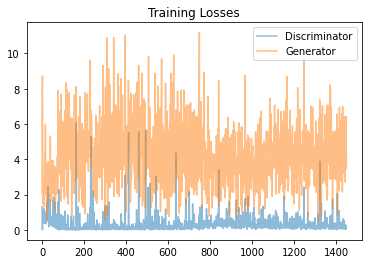

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

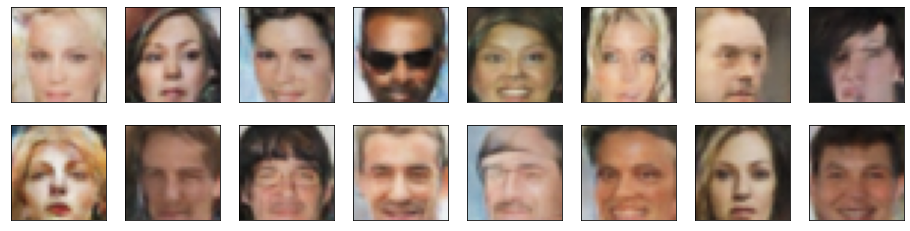

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

To improve the model I think I can use a higher dimesion to generate images, like 64x64 or 128x128. Also, training more epochs could be better. I tried 100 epochs in one tentative but the result was pretty clear with 20 epochs.

The default weight initialization presented similar results to the normal init.

The smooth parameter presented similar results compared to the tests without smooth parameter. 

I could try more deep networks to compare. I create only one variation for my model that had 2 more conv and transpose conv layers. I strided these layers to output the same size as the input, but the results did not improve. Adding some recurrent layers could be interesting to test.

The dataset is biased to celebrity faces but does not interfere in the final results to generate faces. The generated faces will be based on celebrities, not representing all the diversity of the population.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.